In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy, deepcopy
from scipy import special
import pandas as pd
import matplotlib as mpl
from matplotlib.colors import colorConverter
import time
import pystencils
import sympy
from lbmpy.session import *
import math

In [2]:
# SOR iterative method with objects

def SOR_with_objects(N, omega, object_array, conc_mat):
    """
        Function to find final diffusion gradient with objects.
        
        Parameters:
          - N: grid size (NxN)
          - omega : SOR equation constant
          - object_array: a numpy array of 0's and 1's that determine where
            the object is
          - conc_mat: a numpy array containing all concentrations per coordinate
        
        Returns:
        The updated concentration matrix for the diffusion gradient
    """
    
    # initialise parameters
    epsilon = 10 ** -5 # convergence threshold
    diff = 100000 # set to large value    

    # loop until convergence
    while diff > epsilon:
        conc_mat_old = deepcopy(conc_mat)
        conc_mat = SOR(conc_mat, omega, object_array)
        diff = np.amax(np.abs(conc_mat - conc_mat_old))
    return conc_mat

def SOR(conc_mat, omega, object_array):
    """
        Function to find diffusion gradient with objects.
        
        Parameters:
          - conc_mat: a numpy array containing all concentrations per coordinate
          - omega : SOR equation constant
          - object_array: a numpy array of 0's and 1's that determine where
            the object is

        Returns:
        The updated concentration matrix for the diffusion gradient
    """

    # Set inflow boundary to max concentration
    # TODO: this is sun diffusion specific so is liable to change
    conc_mat[N - 1] = 1
    
    # go through left boundary
    for k in range(1, N - 1):
        # if it is part of object, concentration is zero
        if object_array[k][0] == 1:
                conc_mat[k][0] = 0
        # otherwise: SOR equation
        else:
            conc_mat[k][0] = omega / 4 * (conc_mat[k + 1][0] + conc_mat[k - 1][0] + conc_mat[k][1] + conc_mat[k][N - 1]) + (1 - omega) * conc_mat[k][0]

    # loop trough rest/middle of matrix
    for j in range(N - 1):
        for i in range(1, N - 1):
            # if part of object, concentration is zero
            if object_array[i][j] == 1:
                conc_mat[i][j] = 0
            # otherwise: SOR equation
            else:
                conc_mat[i][j] = (omega / 4) * (conc_mat[i + 1][j] + conc_mat[i - 1][j] + conc_mat[i][j + 1] + conc_mat[i][j - 1]) + (1 - omega) * conc_mat[i][j]
                if conc_mat[i][j] < 0:
                    conc_mat[i][j] = 0

    # go through right boundary
    for k in range(1, N - 1):
        # if it is part of object, concentration is zero
        if object_array[k][N - 1] == 1:
            conc_mat[k][N - 1] = 0
        # otherwise: SOR equation
        else:
            conc_mat[k][N - 1] = omega / 4 * (conc_mat[k + 1][N - 1] + conc_mat[k - 1][N - 1] + conc_mat[k][0] + conc_mat[k][N - 2]) + (1 - omega) * conc_mat[k][N - 1]

    return conc_mat

In [3]:
# SOR iterative method with objects - accelerated using CUDA

# We import with exception handling for all the non-CUDA laptops out there :)
try:
    from numba import cuda, float32
    
    @cuda.jit
    def sunlight_kernel(result, conc_mat, object_array, omega, epsilon, max_iter):
        """
            The kernel executed on the GPU. Computes the diffusion of a single
            timestep, contuining until the algorithm converged. Note that the
            algorithm actually checks local convergence; however, with an eta that
            is small enough this shouldn't cause huge differences.

            Parameters:
              - result: The N x N matrix that will contain the diffusion gradient
                at the next timestep
              - conc_mat: The N x N matrix that contains the diffusion
                concentrations at the current timestep
              - object_array: An N x N matrix that describes where the coral is
                with 1's and 0's
              - omega: Constant used in SOR to let the algorithm converge faster.
              - epsilon: The maximum difference between two timesteps before we say
                the algorithm converged
              - max_iter: Maximum number of convergence iterations we do

            Returns:
            nothing
        """

        # First, define a shared array among this block
        diffs = cuda.shared.array(32, dtype=float32)

        # Fetch the size of the area we work on
        N = conc_mat.shape[1]
        rows = N - 2
        cols = N

        # Compute the 2D index of this thread
        block_i = cuda.threadIdx.x
        i = block_i + cuda.blockIdx.x * cuda.blockDim.x
        x, y = i % cols, 1 + i // cols

        # If x and y are outside our interested area, quit
        if x >= cols or y >= 1 + rows:
            return

        # If within bounds, then compute the x-coordinates of the left and right neighbours of this cell
        lx, rx = x - 1, x + 1
        if lx < 0:
            lx = N - 1
        if rx > N - 1:
            rx = 0

        # Keep looping until we converge
        this_timestep = conc_mat
        next_timestep = result
        i = 0
        for i in range(max_iter):
            # Compute the new value from the old one (but only if not a coral block)
            new, old = 0, this_timestep[y, x]
            if object_array[y, x] != 1:
                # Get the average value of all four neighbours
                avg_conc = 1/4 * (this_timestep[y + 1, x] + this_timestep[y - 1, x] + this_timestep[y, rx] + this_timestep[y, lx])

                # Update the current cell using the SOR formula
                new = max(0, omega * avg_conc + (1 - omega) * old)
                if new < 0: new = 0

            # Update the result and the difference
            next_timestep[y, x] = new
            diffs[block_i] = abs(new - old)

            # Since we're done, swap the pointers for the matrices
            temp = this_timestep
            this_timestep = next_timestep
            next_timestep = temp

            # Wait until the other threads in this block reached this point too
            cuda.syncthreads()

            # Bit double work, but search the diffs for the maximum diff. If that's lower than epsilon, we're done
            max_diff = 0
            for diff in diffs:
                if diff > max_diff:
                    max_diff = diff
            if max_diff < epsilon:
                break

            # Otherwise, sync again before the next iteration. Note that this shouldn't cause any deadlocks, as all threads within a block should obtain the same max_diff.
            cuda.syncthreads()

        # If we're done but we last wrote to conc_mat, then copy the results to conc_mat to always have it carry the result
        if i % 2 == 0:
            result[y, x] = conc_mat[y, x]

            
except ImportError as e:
    cuda, float32 = None, None
    print("WARNING: No numba (CUDA) installed, you won't be able to run SOR_with_objects_cuda :(")
import math



def SOR_with_objects_cuda(N, omega, object_array, conc_mat, block_size = 32, max_iter = 100):
    """
        Function to find the final diffusion gradient with objects, using
        the GPU as accelerator.

        Parameters:
          - N: the size of the matrices
          - omega: constant used in the SOR-method to try and let the diffusal
            algorithm converge more quickly
          - object_array: N x N matrix consisting of 1's and 0's, denoting
            where the coral lives
          - conc_mat: N x N matrix that contains the previous diffusal state
            of the sunlight
          - block_size: number of threads per CUDA warp (Default: 32)
          - max_iter: Maximum number of iterations before we always call the
            algorithm converged (Default: 100)

        Result:
        An N x N matrix that describes the diffusion at the next timestep.
    """
    
    # First, check if we have access to a CUDA GPU
    if len(cuda.gpus) == 0:
        raise RuntimeError("No CUDA-capable GPUs detected")
    
    # We set the top row of the new convergence to be 1's
    result = np.zeros(conc_mat.shape, dtype=float)
    for x in range(N):
        result[N - 1, x] = 1
    
    # With the GPU available, prepare the arrays to send to the gpu
    gpu_object_array = cuda.to_device(object_array)
    gpu_conc_mat = cuda.to_device(conc_mat)
    gpu_result = cuda.to_device(result)
    
    # Next, compute the number of blocks needed
    n_blocks = int(math.ceil((N * (N - 2)) / block_size))
    
    # Finally, call the kernel (but override the omega to avoid explosive divergence)
    epsilon = 10**-5
    sunlight_kernel[n_blocks, block_size](gpu_result, gpu_conc_mat, gpu_object_array, 1.0, epsilon, max_iter)
    
    # Once done, retrieve the result
    result = gpu_result.copy_to_host()
    
    # Done, return it!
    return result

In [4]:
def get_candidates_SOR(object_loc, object_array, candidates):
    """
        Function to find the neighbours of an object cell,
        if they qualify as growth candidates, add to set 
        (so all candidates are unique) 
        
        Parameters:
          - object_loc: coordinates tuple of new object cell
          - object_array: a numpy array of 0's and 1's that determine where
            the object is
          - candidates: a set of tuples containing the candidate coordinates
        
        Returns:
        The updated candidate set
    """
    # Get object coordinates
    y = object_loc[0]
    x = object_loc[1]

    # check if edirect neighbours are NOT part of object, and add them to candidates
    if x != N - 1 and object_array[y][x + 1] == 0:
        candidates.add((y, x + 1))
        
    if x != 0 and object_array[y][x - 1] == 0:
        candidates.add((y, x - 1))
        
    if y != N - 1 and object_array[y + 1][x] == 0:
        candidates.add((y + 1, x))
        
    if y != 0 and object_array[y - 1][x] == 0:
        candidates.add((y - 1, x))

    return candidates


def SOR_DLA_to_solution(N, eta, omega, iterations, backend="sequential"):
    """
        Function to calculate the SOR of a grid with object, 
        until convergence, with growing object
        
        Parameters:
          - N: desired grid size (NxN)
          - eta: weight of concentration gradient for growth
          - omega: SOR equation constant
          - iterations: how many times the object should grow
          - backend: Determines which of the SOR algorithms we use for the
            computation. Can be either "sequential", to use the default one,
            or "cuda" to use the one accelerated with CUDA. (Default:
            "sequential")
        
        Returns:
        - The concentration matrix
        - The object_array matrix with fully grown object
    """
    
    # Select the backend
    SOR_backend = None
    if backend == "sequential":
        SOR_backend = SOR_with_objects
    elif backend == "cuda":
        # Make sure CUDA is installed and present, though
        if cuda is None or len(cuda.gpus) == 0:
            raise RuntimeError("numba not installed or no CUDA-capable device present; you cannot use the cuda backend")
        
        # Otherwise, set the backend as usual
        SOR_backend = SOR_with_objects_cuda
    else:
        raise ValueError(f"Unknown backend '{backend}'")
    
    # Calculate the analytic solution at t = 1
    t = 1
    analytic_sol = lambda x, D, t: sum([scipy.special.erfc((1 - x + 2 * i) / (2 * np.sqrt(D * t))) - scipy.special.erfc((1 + x + 2 * i) / (2 * np.sqrt(D * t))) for i in range(10000)])
    x = np.arange(0, 1, 1 / N)
    analytic_matrix = analytic_sol(x, 1, t)
    seed_coor_x = int(N / 2)  # set seed at bottom middle of grid

    # initialise start diffusion gradient as the analytic solution
    conc_mat = np.zeros((N, N))
    for i in range(N):
        conc_mat[i] = analytic_matrix[i]

    # TODO: this is also done in SOR() <- SOR_with_objects()
    # and thus unnecessary here, but left just in case of 
    # nutrient diffusion addition making it needed here
    # (check after big merge)
    # source top boundary
    conc_mat[N - 1] = 1

    # initalisation of array with seed of object
    object_array = np.zeros((N, N))
    object_array[0, seed_coor_x] = 1
    candidates = set()
    candidates = get_candidates_SOR((0, seed_coor_x), object_array, candidates)
    
    # first SOR to initialize starting concentrations
    conc_mat = SOR_backend(N, omega, object_array, conc_mat)
     
    # loop until object is grown 'iterations' times, finding SOR with each growth
    for _ in range(iterations):
        object_array, candidates = choose_growth(N, eta, conc_mat, candidates, object_array)
        conc_mat = SOR_backend(N, omega, object_array, conc_mat)

    plt.imshow(conc_mat, origin='lower', extent=[0, 1, 0, 1], cmap='Spectral')
    
    return conc_mat, object_array


def choose_growth(N, eta, conc_mat, candidates, object_array):
    """
        Function to calculate growth probabilities of each candidate cell,
        choose one and grow it this timestep
        
        Parameters:
          - N: grid size (NxN)
          - eta: weight of concentration gradient for growth
          - conc_mat: numpy array containing all concentrations per coordinate
          - candidates: set of tuple coordinates of all growable cells 
        
        Returns:
        - Updated object_array matrix with newly grown object cell
        - Updated candidate set
    """
    
    # TODO: add necessary input constants as arguments (nutrient diff)
    
    probs = []  # store all candidate grow probabilities
    list_candidates = list(candidates)  # ensure same ordering 
    
    for i in candidates:
        prob_sun = (conc_mat[i] ** eta) / np.sum([conc_mat[cand] ** eta for cand in candidates])
        # TODO: calculate nutrient probability and combine
        # prob_nut =
        # probs.append(alpha * prob_sun + (1 - alpha) * prob_nut)
        probs.append(prob_sun)

    # choose a candidate and grow
    chosen_growth = list_candidates[np.random.choice(len(candidates), p=probs)]
    object_array[chosen_growth] = 1
    conc_mat[chosen_growth] = 0  # set conc to 0 where object has grown
    # update candidate set after growth
    candidates = get_candidates_SOR(chosen_growth, object_array, candidates)
    # delete newly grown cell from growth candidates
    candidates.remove(chosen_growth)
    
    return object_array, candidates
    

In [5]:
# function to make a combined imshow plot, where the object is visible along with the gradient

## code (with small adjustments) based on answer at: https://stackoverflow.com/questions/10127284/overlay-imshow-plots-in-matplotlib
def plot_object_gradient(conc_mat, object_array, eta):
    # generate the colors for your colormap
    color1 = colorConverter.to_rgba('white')
    color2 = colorConverter.to_rgba('black')

    # make the colormaps
    cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_cmap2', [color1,color2], 256)
    cmap2._init() # create the _lut array, with rgba values

    # create your alpha array and fill the colormap with them.
    # here it is progressive, but you can create whathever you want
    alphas = np.linspace(0, 0.8, cmap2.N + 3)
    cmap2._lut[:, -1] = alphas

    img2 = plt.imshow(conc_mat, interpolation='nearest', cmap='Spectral', origin='lower', extent=[0, 1, 0, 1])
    plt.colorbar()
    img3 = plt.imshow(object_array, interpolation='nearest', cmap=cmap2, origin='lower', extent=[0, 1, 0, 1])

    plt.title(f"Object with gradient, eta = {eta}")

    plt.show()

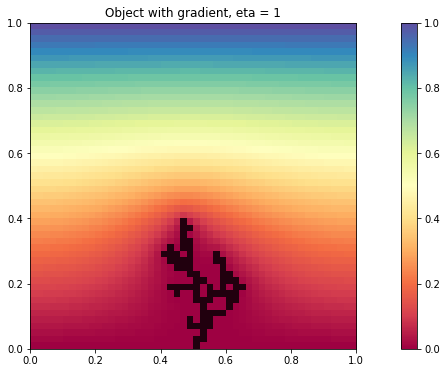

In [6]:
# test run

# initialise parameters
N = 50
eta = 1 
omega = 1.5
iterations = 70

conc_mat, object_array = SOR_DLA_to_solution(N, eta,omega, iterations, backend="sequential")
plot_object_gradient(conc_mat, object_array, 1)

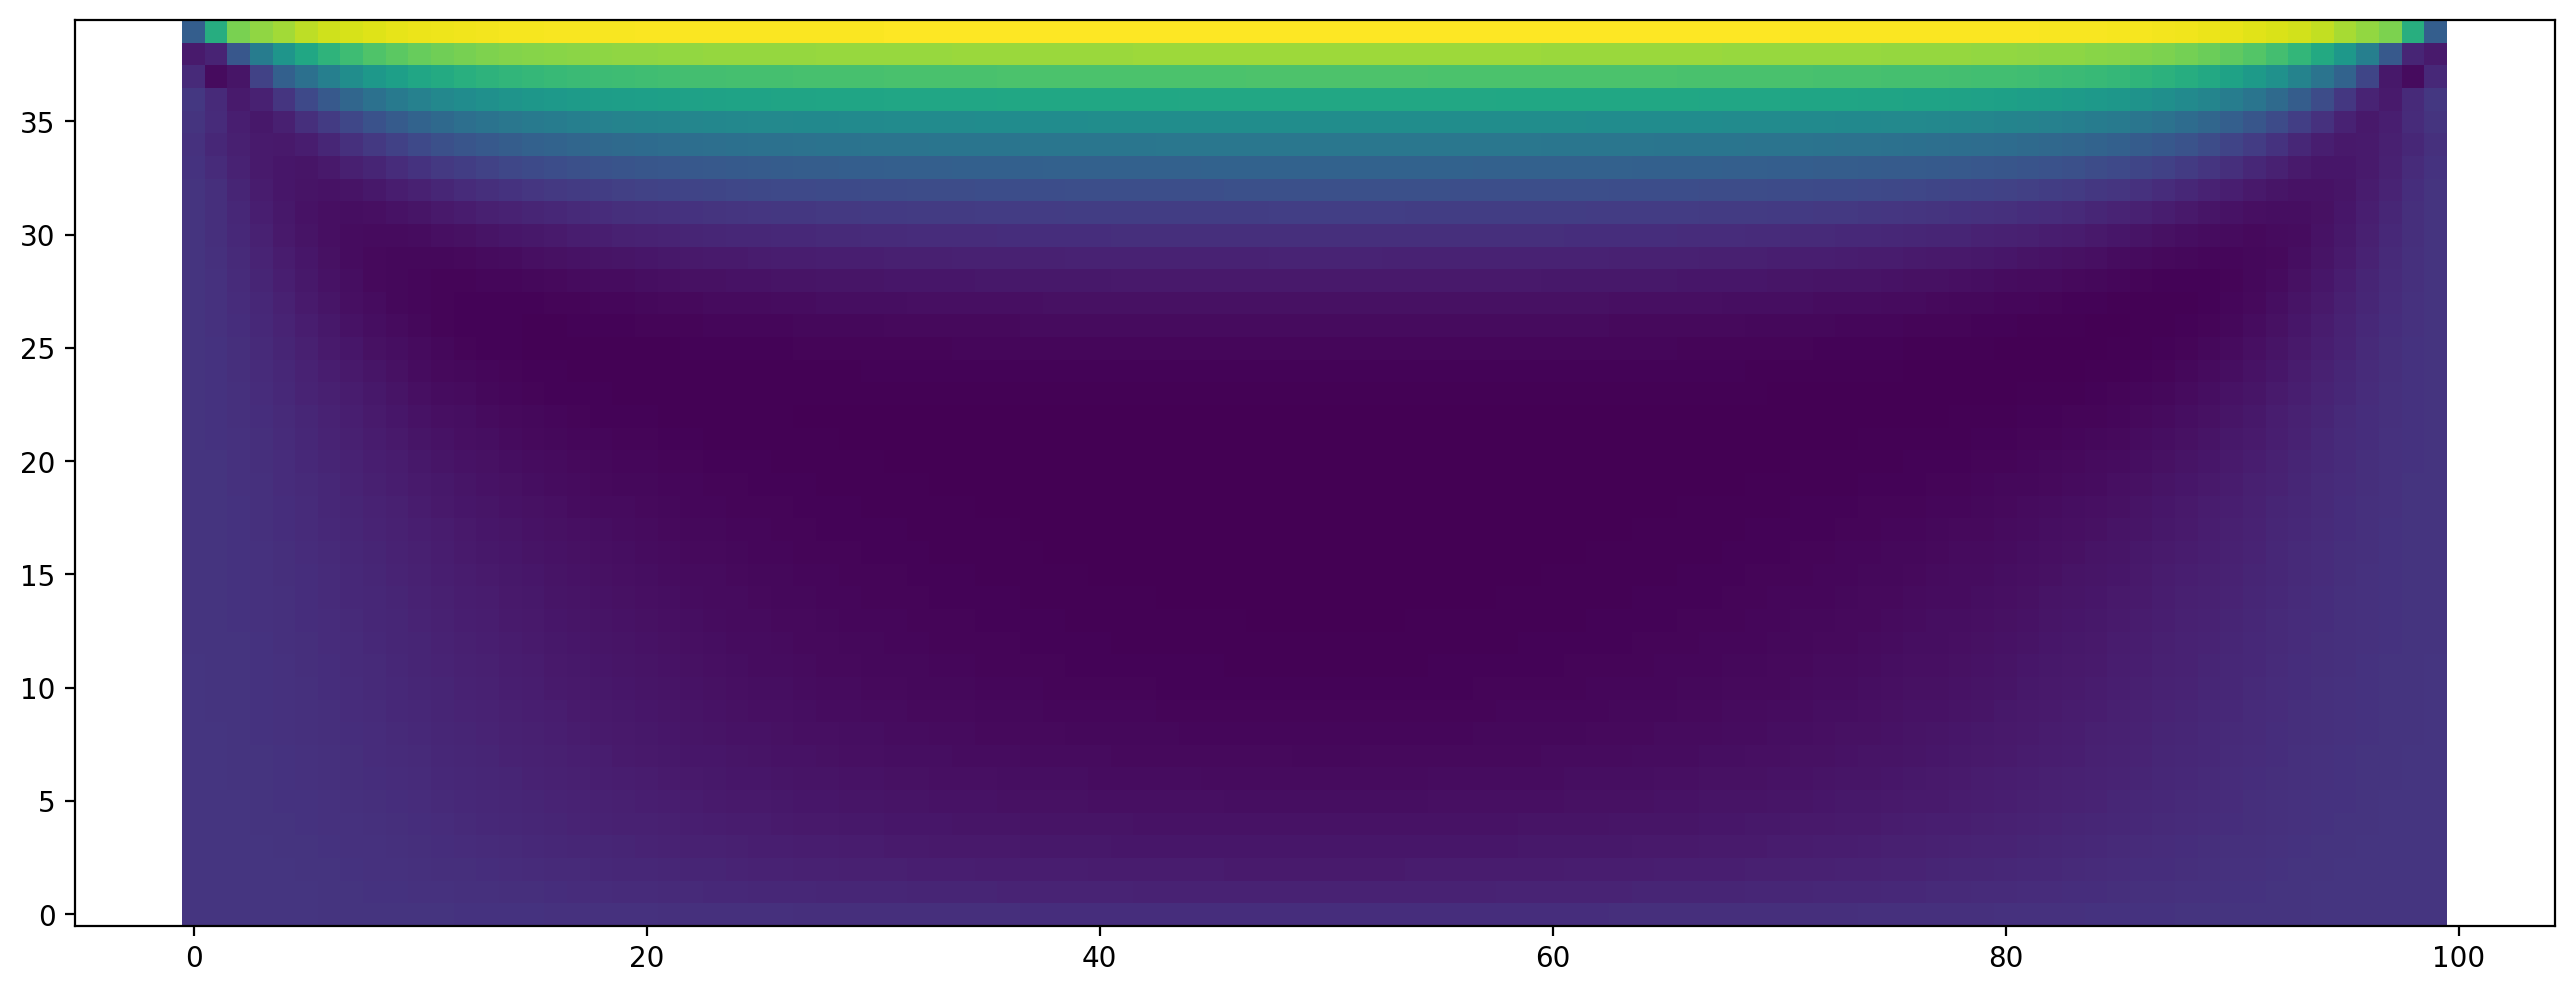

In [7]:
import pystencils
import sympy
from lbmpy.session import *
# example lid driven cavity
ldc = create_lid_driven_cavity(domain_size=(100, 40), method='srt', relaxation_rate=1.6)

ldc.run(500)
plt.figure(dpi=200)
#plt.vector_field(ldc.velocity_slice());

plt.scalar_field(ldc.velocity[:, :, 0])

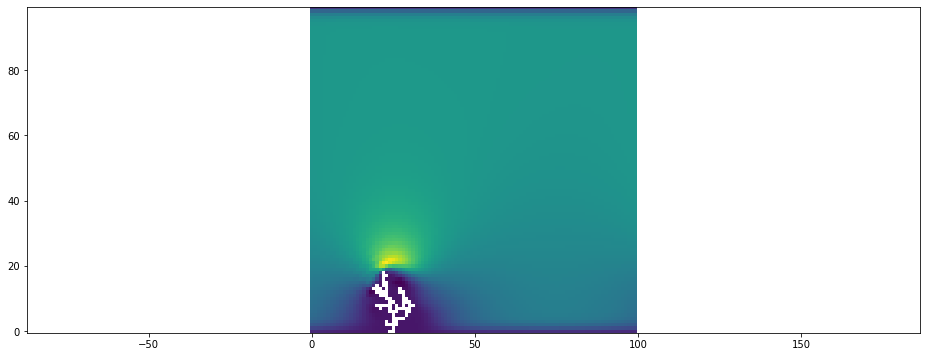

In [8]:
scenario = create_channel(domain_size=(100,100), force=1e-4, duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))

for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j, i])
                
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

In [9]:
# The threshold which the pressure needs to reach before the coral breaks (disappears)
THRESHOLD = 0.005

def coral_breaky_breaky(seed_coord_x, coral_matrix, vector_field, copy=True):
    """
        Function that computes if the coral is gonna breaky breaky
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
          - vector_field: (I assume?) een numpy array of 2D vectors
          - copy: If True, does not modify the original object but instead returns a new one
          
        Returns:
          - The coral matrix with the relevant pixels removed
          - Broken boolean: True if part of coral got removed, else False
          
        O.O does it work?
    """
    
    # Copy the matrix if the user so desires
    if copy:
        coral_matrix = coral_matrix.copy()
    
    # Keep track whether part of coral has broken off
    broken = False
        
    # Loop through the coral matrix to find the corals
    for y in range(len(coral_matrix)):
        for x in range(len(coral_matrix[y])):
            if (x == seed_coord_x and y == 0) or coral_matrix[y][x] == 0: continue

            # Compute the pressure at this point (i.e., length of the vector)
            pressure = math.sqrt(vector_field[x, y][0] ** 2 + vector_field[x, y][1] ** 2)

            # If the pressure exceeds the threshold, remove the coral (:()
            if pressure > THRESHOLD:
                coral_matrix[y][x] = 0
                broken = True

    # We're done! Return the results
    return coral_matrix, broken

In [10]:
def coral_painty_painty(seed_coord_x, coral_matrix, copy=True):
    """
        Function that checks which pixels are still connected to the source,
        and removes them. Also returns a new list of potential growth
        candidates.
        
        Note: We assume that a diagonal connection == no connection
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
          - copy: If True, does not modify the original object but instead returns a new one
        
        Returns:
        A tuple of:
          - The coral matrix, with all the unconnected pixels removed
          - A new list of growth candidates
    """
    
    # Copy the matrix if the user so desires
    if copy:
        coral_matrix = coral_matrix.copy()
        
    # Do a breadth-first search starting at the seed to see which pixels are connected to the seed
    coral_matrix[0][seed_coord_x] = 2
    to_do = [(seed_coord_x, 0)]
    candidates = set()
    while len(to_do) > 0:
        # Fetch the pixel to check
        x, y = to_do[0]
        to_do = to_do[1:]
        
        # Get the area around the pixel
        for neighbour in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
            nx = x + neighbour[0]
            ny = y + neighbour[1]
            
            # Skip if the pixel is out-of-bounds
            if nx < 0 or nx > coral_matrix.shape[0] - 1 or ny < 0 or ny > coral_matrix.shape[1] - 1:
                continue
            
            # If the pixel is not a pixel, then store it as possible growth candidate
            if coral_matrix[ny][nx] == 0:
                # Uncomment for the correct candidates order
#                 candidates.add((nx, ny))
                candidates.add((ny, nx))
            
            # If it is an (unvisited) pixel, then mark as visited/connected and add it to the todo list
            if coral_matrix[ny][nx] == 1:
                # Mark the pixel as connected
                coral_matrix[ny][nx] = 2
                
                # Add to the queue
                to_do.append((nx, ny))
    
    # Go thru the matrix again and remove anything that's a 1
    coral_matrix[coral_matrix == 1] = 0
    # Convert the visited pixels back to 1's
    coral_matrix[coral_matrix == 2] = 1
    
    # Done!
    return coral_matrix, candidates


In [11]:
def coral_density(seed_coord_x, coral_matrix):
    """
        Function that computes the average distance per pixel to the source
        for the entire coral.
        
        Parameters:
          - seed_coord_x: the x-coordinate of the seed of the coral (the y is
            assumed to be 0)
          - coral_matrix: a numpy array of 0's and 1's that determine where
            the coral is
        
        Returns:
        The average distance of the coral. The lower, the denser.
    """
    
    # Search through the coral
    total_distance = 0
    n_pixels = 0
    for y in range(len(coral_matrix)):
        for x in range(len(coral_matrix[y])):
            # If not a coral or the source block, then skip
            if (x == seed_coord_x and y == 0) or coral_matrix[y][x] != 1: continue

            # If coral, then compute the distance to the source block
            total_distance += math.sqrt((x - seed_coord_x)**2 + y**2)
            n_pixels += 1

    # To return the average distance, we return total / count
    return total_distance / n_pixels

In [12]:
print(object_array[object_array>=1].shape)

(71,)


In [13]:
object_array_test = object_array.copy()

test_space = int(N / 4)
object_array_test[test_space, test_space] = 1
object_array_test[test_space + 1, test_space] = 1
object_array_test[test_space, test_space + 1] = 1
object_array_test[test_space, test_space] = 1

object_array_trimmed, candidates_trimmed = coral_painty_painty(int(N / 2), object_array_test, True)

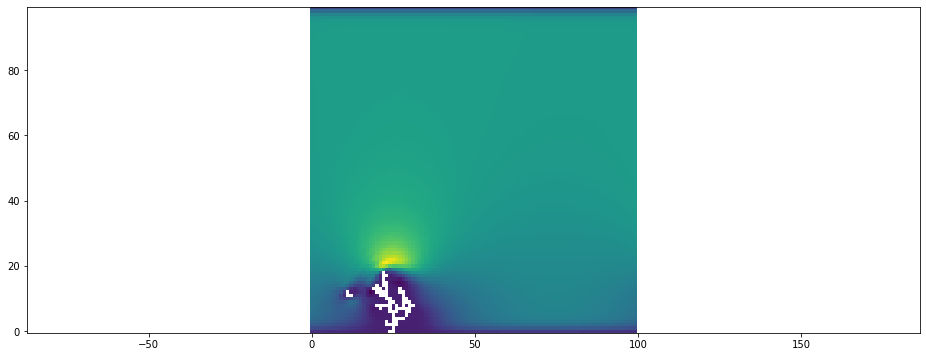

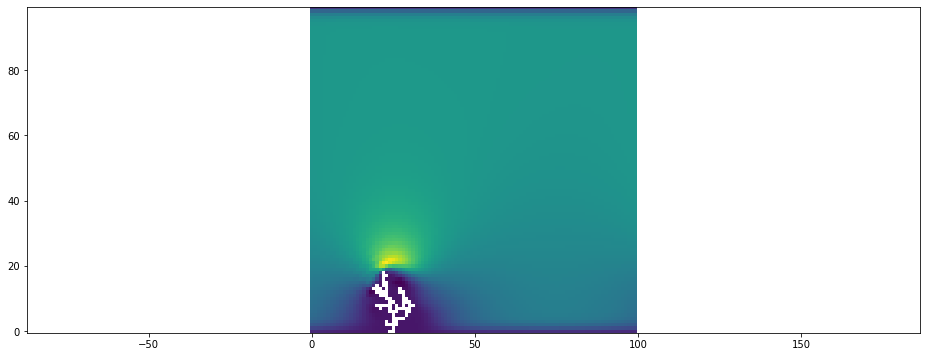

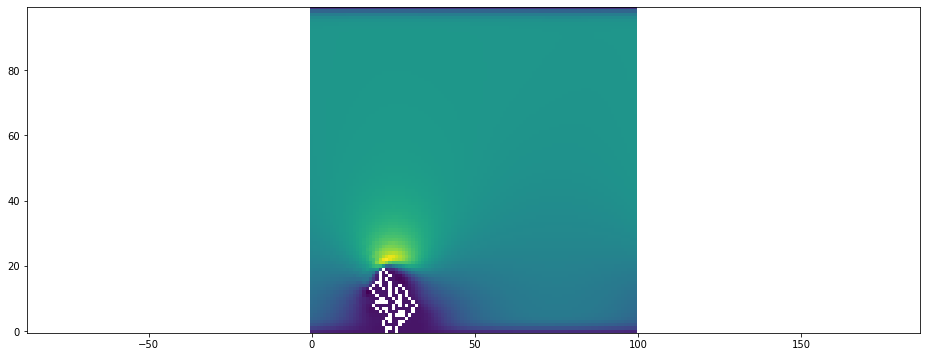

In [14]:
scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array_test[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for j in range(N-1):
    for i in range(1,N-1):
        # if part of object, concentration is zero
            if object_array_trimmed[i][j] == 1:
                flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

scenario = create_channel(domain_size=(100,100), force=1e-4,duct=True, method='srt', relaxation_rate=1.9)
#flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[0.3:0.4, 0.0:0.3])
#print(np.where(object_array==1))


for i, j in candidates_trimmed:
    flag = scenario.boundary_handling.set_boundary(NoSlip(), make_slice[j,i])
scenario.run(500)

plt.figure()
plt.scalar_field(scenario.velocity[:,:,0])
# plt.vector_field(scenario.velocity_slice());

In [15]:
print(coral_density(50, object_array_trimmed))

26.30165549747392


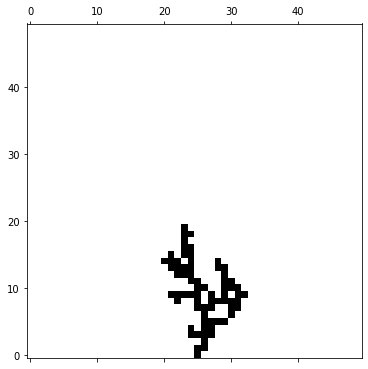

In [16]:
object_array_trimmed

import matplotlib.pyplot as plt
# plt.matshow(object_array_trimmed)
plt.matshow(object_array_trimmed, cmap = plt.cm.binary, origin='lower')

In [31]:
def branch_factor(coral_matrix):
    """
        Function that computes The fraction of coral cells which are center cells. 
        The higher the number the more dense the coral is.
        Parameters:
          - coral matrix
        
        Returns:
            The fraction of cells which are only surrounded by coral.
    """
    edge_cells = set()
    coral_size = 0
    for row in range(len(coral_matrix)):
        for element in range(len(coral_matrix)):
            # If cell is not coral, continue            
            if coral_matrix[row][element] == 0:
                continue
            else:
                coral_size +=1
                # Check all neighbours
                for neighbour in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
                    nx = row + neighbour[0]
                    ny = element + neighbour[1]
            
                    # Skip if the pixel is out-of-bounds
                    if nx < 0 or nx > coral_matrix.shape[0] - 1 or ny < 0 or ny > coral_matrix.shape[1] - 1:
                        continue
                        
                    # If neighbour is sea, the cell is an edge.
                    if coral_matrix[nx][ny] == 0:
                        edge_cells.add((row, element))
                        break
            
    core_cells = (coral_size-1) - (len(edge_cells)-1)
    
    return(core_cells/(coral_size-1))
    
    
dense = branch_factor(object_array_trimmed)
print(dense)

0.04285714285714286


In [29]:
print(3/70)

0.04285714285714286


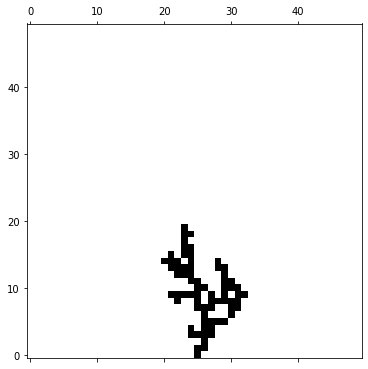

In [19]:
# tester = object_array_trimmed
# tester[0][25] = 2
plt.matshow(object_array_trimmed, cmap = plt.cm.binary, origin='lower')

In [ ]:
print(len(object_array_trimmed))
print(object_array_trimmed[0])
print(N)